In [250]:
import requests
import pandas as pd
from google.cloud import translate_v2 as translate
from openai import OpenAI
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.translate.nist_score import sentence_nist
import matplotlib.pyplot as plt
from ibm_watson import LanguageTranslatorV3
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

# Import Data

In [251]:
def get_urls(owner, repo, path):
    # Construct the URL for the GitHub API
    api_url = f"https://api.github.com/repos/{owner}/{repo}/contents/{path}"
    
    # Fetch the content of the GitHub repository
    response = requests.get(api_url)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Parse the response to extract file names, file objects, and file URLs
        names = [file['name'] for file in response.json()]
        urls = [f"https://raw.githubusercontent.com/{owner}/{repo}/main/{path}/{name}" for name in names]  # URLs to each file
        
        # Print the list of files and their corresponding URLs
        print("Files in the GitHub repository folder:")
        for name, url in zip(names, urls):
            print(f"{name}: {url}")
        
        return names, urls
    else:
        # If the request was not successful, print an error message
        print(f"Error: Failed to fetch content from GitHub repository. Status code: {response.status_code}")
        return [], []

In [252]:
# GitHub repository information
owner = "rnagamatsu"
repo = "textanalytics_group2"
path = "flores200_group2"

# Get the list of files in the GitHub repository folder
files_names, files_urls = get_urls(owner, repo, path)

Files in the GitHub repository folder:
eng_Latn.dev: https://raw.githubusercontent.com/rnagamatsu/textanalytics_group2/main/flores200_group2/eng_Latn.dev
hin_Deva.dev: https://raw.githubusercontent.com/rnagamatsu/textanalytics_group2/main/flores200_group2/hin_Deva.dev
ind_Latn.dev: https://raw.githubusercontent.com/rnagamatsu/textanalytics_group2/main/flores200_group2/ind_Latn.dev
jpn_Jpan.dev: https://raw.githubusercontent.com/rnagamatsu/textanalytics_group2/main/flores200_group2/jpn_Jpan.dev
kor_Hang.dev: https://raw.githubusercontent.com/rnagamatsu/textanalytics_group2/main/flores200_group2/kor_Hang.dev
spa_Latn.dev: https://raw.githubusercontent.com/rnagamatsu/textanalytics_group2/main/flores200_group2/spa_Latn.dev
tha_Thai.dev: https://raw.githubusercontent.com/rnagamatsu/textanalytics_group2/main/flores200_group2/tha_Thai.dev
vie_Latn.dev: https://raw.githubusercontent.com/rnagamatsu/textanalytics_group2/main/flores200_group2/vie_Latn.dev


In [253]:
def process_flores(files_names, files_urls):
    dfs = []

    for index, (name, url) in enumerate(zip(files_names, files_urls)):
        response = requests.get(url)
        if response.status_code == 200:
            print(f"Downloaded and processed file {index+1}/{len(files_names)}: {name}")
            text = response.text
            df_name = name[:3]
            df = pd.DataFrame(text.split('\n'), columns=[df_name])
            dfs.append(df)
        else:
            print(f"Error: Failed to download file {name}")

    # Concatenate the DataFrames along the columns axis
    if dfs:
        concatenated_df = pd.concat(dfs, axis=1)
        # Last row is empty
        concatenated_df.drop(concatenated_df.index[-1], inplace=True)
        return concatenated_df
    else:
        print("No DataFrames to concatenate.")
        return None

In [254]:
references = process_flores(files_names, files_urls)

Downloaded and processed file 1/8: eng_Latn.dev


Downloaded and processed file 2/8: hin_Deva.dev
Downloaded and processed file 3/8: ind_Latn.dev
Downloaded and processed file 4/8: jpn_Jpan.dev
Downloaded and processed file 5/8: kor_Hang.dev
Downloaded and processed file 6/8: spa_Latn.dev
Downloaded and processed file 7/8: tha_Thai.dev
Downloaded and processed file 8/8: vie_Latn.dev


In [255]:
# Rename columns to universal language code
references.columns = ['en', 'hi', 'id', 'ja', 'ko', 'es', 'th', 'vi']

In [256]:
# Reduce the size of the data for the analysis
references = references[:15]

In [257]:
references

,en,hi,id,ja,ko,es,th,vi
0,"On Monday, scientists from the Stanford Univer...","सोमवार को, स्टैनफ़ोर्ड यूनिवर्सिटी स्कूल ऑफ़ म...",Ilmuwan dari Stanford University School of Med...,月曜日にスタンフォード大学医学部の科学者たちは、細胞を種類別に分類できる新しい診断ツールを発...,스탠포드 의과대학 연구진은 지난 월요일 세포를 유형별로 분류할 수 있는 새로운 진단...,"El lunes, los científicos de la facultad de me...",เมื่อวันจันทร์ที่ผ่านมา นักวิทยาศาสตร์จากโรงเร...,"Vào hôm thứ Hai, các nhà khoa học thuộc Trường..."
1,Lead researchers say this may bring early dete...,शोधकर्ताओं ने कहा है कि यह अल्प आय वाले देशों ...,Ketua peneliti mengatakan bahwa diagnosis ini ...,主任研究者は、これは低所得国における患者の癌、結核、HIV、マラリアの早期発見につながる可能...,수석 연구진들은 이것이 선진국 대비 절반의 생존율을 보이는 저소득 국가들의 환자들에...,Los principales investigadores principales sos...,นักวิจัยชั้นนำกล่าวว่าสิ่งนี้อาจทำให้มีการตรวจ...,Các nhà nghiên cứu chính nói rằng điều này có ...
2,The JAS 39C Gripen crashed onto a runway at ar...,स्थानीय समय (0230 UTC) के मुताबिक करीब 9:30 बज...,JAS 39C Gripen jatuh ke landasan pacu sekitar ...,JAS 39Cグリペンは現地時間の午前9時30分頃（UTC 0230）に滑走路に墜落して爆発...,현지 시간으로 약 아침 9시 30분(0230 UTC)에 JAS 39C 그리펜이 활주...,El JAS 39C Gripen impactó contra una pista cer...,JAS 39C Gripen ตกลงบนรันเวย์เมื่อเวลาประมาณ 09...,Chiếc JAS 39C Gripen đâm xuống đường băng vào ...
3,The pilot was identified as Squadron Leader Di...,पायलट की पहचान स्क्वाड्रन लीडर दिलोकृत पटावी क...,Pilot tersebut diidentifikasi sebagai Pemimpin...,操縦士は中隊長のディロクリット・パタヴェー氏であることが確認されました。,그 조종사는 비행 중대장 딜로크리트 패타비로 확인되었다.,Se identificó al piloto como Dilokrit Pattavee...,นักบินคนดังกล่าวถูกระบุว่าเป็นนาวาอากาศตรีดิลก...,Viên phi công được xác định là Chỉ huy đội bay...
4,Local media reports an airport fire vehicle ro...,स्थानीय मीडिया ने बताया है कि कार्रवाई करने के...,Media lokal melaporkan sebuah kendaraan pemada...,地元メディアの報道によると、空港の消防車が対応中に横転したということです。,현지 언론은 공항 소방차가 사고에 대응하는 도중에 전복되었다고 보도했습니다.,La prensa local informó que una patrulla de bo...,ผู้สื่อข่าวท้องถิ่นรายงานว่ารถดับเพลิงประจำสนา...,Truyền thông địa phương đưa tin một phương tiệ...
5,28-year-old Vidal had joined Barça three seaso...,28 वर्षीय विडाल तीन सीजन पहले सेविला से बारका ...,Vidal yang berusia 28 tahun bergabung dengan B...,28歳のビダル選手は、3シーズン前にセビージャから移籍してバルサに所属していました。,28세인 비달은 3년 전 세비야 FC에서 FC 바르셀로나에 합류했습니다.,"Vidal, de 28 años de edad y procedente del Sev...",วิดัลวัย 28 ปี ย้ายจากเซบีญ่ามาเข้าร่วมกับบาร์...,"Ba mùa trước, Vidal đã rời Sevilla để gia nhập..."
6,"Since moving to the Catalan-capital, Vidal had...",कातलान की राजधानी (बार्सिलोना) में जाने के बाद...,"Sejak menetap di ibu kota Catalan, Vidal sudah...",カタルーニャの州都に移って以来、ビダルはクラブで49試合に出場しました。,바르셀로나로 이적한 후 비달은 클럽을 위해 49경기를 뛰었습니다.,"Desde su mudanza a la capital catalana, Vidal ...",นับตั้งแต่ย้ายมาที่เมืองหลวงของกาตาลุญญา วิดัล...,"Từ khi chuyển đến thủ phủ của xứ Catalan, Vida..."
7,The protest started around 11:00 local time (U...,व्हाइटहॉल पर लगभग 11:00 बजे स्थानीय समय (यूटीस...,Protes dimulai sekitar pukul 11.00 waktu setem...,抗議行動は、現地時間11:00（UTC+1）頃にホワイトホール通りで始まり、首相官邸があるダ...,시위는 총리의 공식 거주지인 다우닝가의 경찰이 경비를 서는 입구 맞은편 화이트홀에서...,La manifestación inició cerca de las 11:00 hor...,การประท้วงเริ่มขึ้นประมาณ 11.00 น. ตามเวลาท้อง...,Cuộc biểu tình bắt đầu vào khoảng 11:00 giờ sá...
8,"Just after 11:00, protesters blocked traffic o...","ठीक 11:00 बजे के बाद, व्हाइटहॉल में उत्तर की ओ...",Pengunjuk rasa tepat setelah pukul 11.00 membl...,11時すぎちょうどに抗議者たちはホワイトホールの北行き車両の交通を遮断しました。,"11시가 막 지난 후, 시위대는 화이트홀에 있는 북쪽으로 향하는 마차들의 교통을 막았다.","Apenas pasadas las 11:00 h, los integrantes de...",หลังเวลา 11.00 น. พอดิบพอดี ผู้ประท้วงปิดกั้นก...,Ngay sau 11 giờ những người biểu tình đã chặn ...
9,"At 11:20, the police asked the protesters to m...","11:20 पर, पुलिस ने प्रदर्शनकारियों को यह कहते ...","Pada pukul 11.20, polisi meminta para pengunju...",11時20分になると、警察は抗議する権利と交通量のバランスを弁える必要があると告げて、抗議者...,"11시 20분에 경찰이 시위대에게 보도로 돌아가도록 요청했으며, 시위할 권리와 증가...","A las 11:20, la policía solicitó a los manifes...",เมื่อเวลา 11.20 น. ตำรวจได้ขอให้ผู้ประท้วงย้าย...,"Vào lúc 11:20, cảnh sát đã yêu cầu người biểu ..."


# Translation

### Google Translate

In [258]:
# Set the path to your service account key file
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "ta-msba-group-2-e04caadf49d8.json"

# Initialize the Translate API client
translator = translate.Client()

In [259]:
def google_translate_df(input_df, target_language):
    translated_df = pd.DataFrame()

    for col in input_df.columns:
        translated_col = []
        for cell in input_df[col]:
            # Translate each cell using Google Translate
            translation = translator.translate(cell, target_language=target_language)
            translated_text = translation['translatedText']
            translated_col.append(translated_text)
        translated_df[col] = translated_col

    return translated_df

In [260]:
google_candidates = google_translate_df(references.drop(columns=['en']), "en")

In [261]:
# Print the resulting DataFrame
google_candidates

,hi,id,ja,ko,es,th,vi
0,"On Monday, scientists at Stanford University S...",Scientists from Stanford University School of ...,Scientists at the Stanford University School o...,Researchers at Stanford University School of M...,"On Monday, scientists at Stanford University S...",last Monday Scientists at Stanford University ...,"On Monday, scientists at the Stanford Universi..."
1,Researchers say this could help easily identif...,The lead researcher said that this diagnosis c...,Lead researchers say this could lead to earlie...,Lead researchers explain that this could lead ...,Leading senior researchers argue that this may...,Leading researchers say this could allow for e...,The lead researchers say this could help early...
2,"At around 9:30 am local time (0230 UTC), the J...",The JAS 39C Gripen crashed onto the runway at ...,The JAS 39C Gripen crashed on the runway and e...,At approximately 9:30 am local time (0230 UTC)...,The JAS 39C Gripen hit a runway around 9:30 a....,The JAS 39C Gripen crashed onto the runway at ...,The JAS 39C Gripen crashed into the runway at ...
3,The pilot was identified as Squadron Leader Di...,The pilot was identified as Squadron Leader Di...,The pilot was identified as Squadron Leader Di...,The pilot was identified as Squadron Leader Di...,"The pilot was identified as Dilokrit Pattavee,...",The pilot has been identified as Wing Commande...,The pilot was identified as Flight Commander D...
4,Local media has reported that the airport&#39;...,Local media reported that a fire extinguisher ...,Local media reports said an airport fire truck...,Local media reported that the airport fire tru...,The local press reported that an airport fire ...,Local reporters reported that airport fire tru...,Local media reported that an airport firefight...
5,"Vidal, 28, joined Barca from Sevilla three sea...",The 28-year-old Vidal joined BarÃ§a three seas...,The 28-year-old Vidal joined Barca from Sevill...,"Vidal, 28, joined FC Barcelona from Sevilla FC...","Vidal, 28 years old and from Sevilla, joined B...","Vidal, 28, joined Barca from Sevilla three sea...","Three seasons ago, Vidal left Sevilla to join ..."
6,Since moving to the Catalan capital (Barcelona...,"Since settling in the Catalan capital, Vidal h...","Since moving to the Catalan capital, Vidal has...","After moving to Barcelona, Vidal played 49 gam...","Since moving to the Catalan capital, Vidal has...",Since moving to the Catalan capital Vidal has ...,"Since moving to the Catalan capital, Vidal has..."
7,The protest began at around 11:00 am local tim...,The protest began at around 11:00 local time (...,The protest began at around 11:00 local time (...,The protest began around 11:00 local time (UTC...,The demonstration began around 11:00 local tim...,The protest began around 11:00 AM local time (...,The protest began at around 11:00 a.m. local t...
8,"Just after 11:00 a.m., northbound traffic on W...",Protesters just after 11am blocked northbound ...,"Just after 11am, protesters blocked northbound...","Just after 11 o&#39;clock, protesters blocked ...","Just after 11:00 a.m., members of the demonstr...","Just after 11:00 AM, protesters blocked traffi...",Just after 11am protesters blocked traffic on ...
9,"At 11:20, police asked protesters to return to...","At 11:20 a.m., police asked the protesters to ...","At 11:20 p.m., police asked protesters to retu...",At 11:20 police asked protesters to return to ...,"At 11:20, police asked protesters to move back...","At 11:20 a.m., police asked protesters to move...","At 11:20, police asked protesters to retreat t..."


### IBM Watson Language Translator

In [247]:
# Defining API key and URL
with open('ibm_api.txt', 'r') as file:
    ibm_api_key = file.read()

url = 'https://api.eu-gb.language-translator.watson.cloud.ibm.com/instances/b0153ef1-fe8f-450d-b691-9abba034bcdd'

# Authenticating the API key
authenticator = IAMAuthenticator(apikey=ibm_api_key)

# Creating the Language Translator object
ibm_translator = LanguageTranslatorV3(
    version='2018-05-01',
    authenticator=authenticator
)

# Setting the service URL
ibm_translator.set_service_url(url)


            On 10 June 2023, IBM announced the deprecation of the Natural Language Translator service.
            The service will no longer be available from 8 August 2022. As of 10 June 2024, the service will reach its End of Support
            date. As of 10 December 2024, the service will be withdrawn entirely and will no longer be
            available to any customers.
            


In [248]:
def ibm_translate_df(input_df, target_language):
    translated_df = pd.DataFrame()

    for col in input_df.columns:
        translated_col = []
        model = col + "-" + target_language
        for cell in input_df[col]:
            # Translate each cell using Google Translate
            translation = ibm_translator.translate(
                            text = cell,
                            model_id = model
                        ).get_result()
            translated_text = translation['translations'][0]['translation']
            translated_col.append(translated_text)
        translated_df[col] = translated_col

    return translated_df

In [ ]:
ibm_candidates = ibm_translate_df(references.drop(columns=['en']), "en")

### ChatGPT

In [210]:
with open('chat_gpt_api.txt', 'r') as file:
    gpt_api_key = file.read()

client = OpenAI(api_key=gpt_api_key)

In [196]:
def chatgpt_translate_df(input_df, target_language):
    translated_df = pd.DataFrame()
    for col in input_df.columns:
        translated_col = []
        for cell in input_df[col]:
            # Translation request to OpenAI using GPT4
            response = client.chat.completions.create(
                model="gpt-4", # Change to "gpt-3.5-turbo" to run on GPT3.5
                messages=[
                    {"role": "user", "content": f"Translate the following text to {target_language}: {cell}"}
                ],
                stream=True
            )
            # Processing the streaming response
            translated_text = ''
            for chunk in response:
                if chunk.choices[0].delta.content is not None:
                    translated_text += chunk.choices[0].delta.content
            translated_col.append(translated_text)
        translated_df[col] = translated_col

    return translated_df

In [200]:
chatgpt_candidates = chatgpt_translate_df(references.drop(columns=['eng']), "English")

# Tokenization

In [262]:
# Ensure NLTK is downloaded
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [264]:
references_tokenized = [word_tokenize(sentence) for sentence in references['en']]

In [265]:
def tokenize_dataframe(input_df):
    # Create a new DataFrame for tokenized strings
    tokenized_df = pd.DataFrame()

    # Tokenize strings in all columns and add them to the tokenized_df
    for col in input_df.columns:
        tokenized_df[col] = input_df[col].apply(lambda x: word_tokenize(x))

    return tokenized_df

In [201]:
google_candidates_tokenized = tokenize_dataframe(google_candidates)

In [ ]:
chatgpt_candidates_tokenized = tokenize_dataframe(chatgpt_candidates)

In [ ]:
ibm_candidates_tokenized = tokenize_dataframe(ibm_candidates)

In [202]:
google_candidates_tokenized

,hin,ind,jpn,kor,spa,tha,vie
0,"[On, Monday, ,, scientists, from, Stanford, Un...","[Scientists, from, Stanford, University, Schoo...","[On, Monday, ,, scientists, from, Stanford, Un...","[Researchers, from, Stanford, University, 's, ...","[On, Monday, ,, scientists, from, the, Stanfor...","[Last, Monday, ,, scientists, from, Stanford, ...","[On, Monday, ,, scientists, from, Stanford, Un..."


# Evaluation

In [267]:
def compute_nist_score(references, candidates_df):
    # Initialize an empty DataFrame to store the BLEU scores
    nist_df = pd.DataFrame()

    # Iterate over the specified columns
    for col in candidates_df.columns:
        # Compute NIST score for each pair of sentences in the corresponding columns
        nist_scores = []
        for sent1, sent2 in zip(references, candidates_df[col]):
            nist_score = sentence_nist([sent1], sent2)
            nist_scores.append(nist_score)

        # Add BLEU scores to the DataFrame
        nist_df[col] = nist_scores
        
        # Format the numbers as decimals
        nist_df = nist_df.map(lambda x: round(x, 3))

    return nist_df

In [268]:
google_nist = compute_nist_score(references_tokenized, google_candidates_tokenized)

In [ ]:
chatgpt_nist = compute_nist_score(references_tokenized, chatgpt_candidates_tokenized)

In [ ]:
ibm_nist = compute_nist_score(references_tokenized, ibm_candidates_tokenized)

In [269]:
google_nist

,hi,id,ja,ko,es,th,vi
0,4.905,4.164,3.420,2.860,4.133,3.958,4.472
1,3.468,3.490,4.372,3.481,3.588,4.173,3.875
2,3.525,4.006,3.722,3.979,3.949,3.059,3.846
3,2.990,3.322,2.990,2.658,2.416,1.812,2.658
4,1.434,1.792,2.151,1.673,1.280,1.103,1.870
5,2.689,2.987,2.841,2.049,2.390,2.689,1.344
6,2.829,2.010,2.628,3.038,3.116,2.552,2.872
7,2.908,3.420,3.086,3.568,2.131,2.710,3.126
8,2.991,1.896,2.709,2.115,2.464,3.046,2.862
9,3.170,3.565,3.175,2.224,3.265,3.455,2.499


In [184]:
def calculate_stats(df):
    # Calculate mean and standard deviation for each column
    mean_values = df.mean()
    std_values = df.std()
    
    # Create a DataFrame to store the results
    stats_df = pd.DataFrame({'variable': ['mean', 'sd']})
    
    # Add mean and standard deviation values for each column
    for col in df.columns:
        stats_df[col] = [mean_values[col], std_values[col]]
    
    return stats_df

In [188]:
google_nist_stats = calculate_stats(google_nist)

In [ ]:
chatgpt_nist_stats = calculate_stats(chatgpt_nist)

In [ ]:
ibm_nist_stats = calculate_stats(ibm_nist)

In [189]:
google_nist_stats

,variable,hin,ind,jpn,kor,spa,tha,vie
0,mean,3.018400,3.084050,2.827500,2.769350,2.739550,2.767150,2.877250
1,sd,0.685078,0.760766,0.661392,0.662021,0.708478,0.749431,0.783708


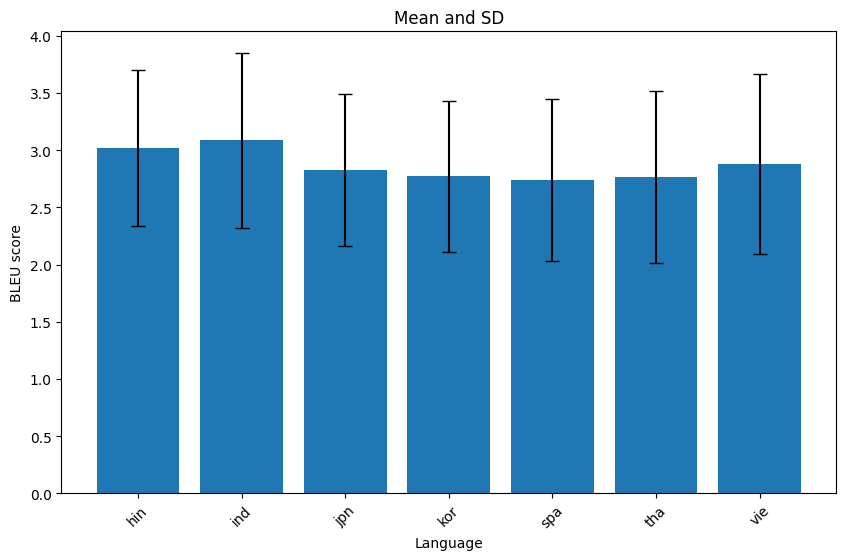

In [190]:
# Extract mean values and standard deviations
means = google_nist_stats.loc[google_nist_stats['variable'] == 'mean'].drop(columns='variable').iloc[0]
stds = google_nist_stats.loc[google_nist_stats['variable'] == 'sd'].drop(columns='variable').iloc[0]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(means.index, means, yerr=stds, capsize=5)
plt.title('Mean and SD')
plt.xlabel('Language')
plt.ylabel('NIST score')
plt.xticks(rotation=45)
plt.show()